## Imports and Load Dictionaries

In [19]:
import os
import re
import csv
import json
import random
from openai import OpenAI
from dotenv import load_dotenv
from llm_generate import get_all_paths, get_samples, get_generate_fewshot, process_mwo_response, BLACKLIST
from llm_prompt import initialise_prompts, check_similarity

load_dotenv()
api_key = os.getenv('API_KEY')
client = OpenAI(api_key=api_key)
paths_list, paths_dict = get_all_paths(valid=True)

49	paths in object_property_paths
391	paths in process_agent_paths
269	paths in process_patient_paths
1208	paths in state_patient_paths
3	paths in object_property_state_paths
0	paths in object_process_state_paths
607	paths in state_agent_activity_paths
37	paths in state_agent_patient_paths
1229	paths in process_agent_patient_paths
Total number of paths: 3793


In [20]:
def get_prompt(object, event, after):
    if not after:
        prompt = (
            "Generate 5 different Maintenance Work Order (MWO) sentence describing the following equipment undesirable event.\n" 
            f"Equipment: {object}\n"
            f"Undesirable Event: {event}\n"
            "You must use all terms given above and do not add new information.\n"
            "Each sentence can have a maximum of 8 words.\n"
        )
    else:
        blacklist = ["'"+word+"'" for word in BLACKLIST]
        blacklist = ', '.join(blacklist)
        prompt = (
        "Generate 5 different Maintenance Work Order (MWO) sentence describing the following equipment undesirable event.\n" 
        f"Equipment: {object}\n"
        f"Undesirable Event: {event}\n"
        "You must use all terms given above and do not add new information.\n"
        "Avoid verbosity and use minimal stop words.\n"
        "Each sentence can have a maximum of 8 words.\n"
        f"Do not use these terms: {blacklist}.\n"
    )
    return prompt

def get_fewshot(after=False):
    message = [{"role": "system", "content": "You are a technician recording maintenance work orders."}]
    with open("fewshot_messages/fewshot_generate.csv", encoding='utf-8') as f:
        fewshot_data = csv.reader(f)
        next(fewshot_data) # Ignore header
        for row in fewshot_data:
            object_name = row[0]
            event_name = f"{row[1]} {row[2]}".strip()
            if not after:
                prompt = get_prompt(object_name, event_name, after=False)
            else:
                prompt = get_prompt(object_name, event_name, after=True)            
            user = {"role": "user", "content": prompt}
            example = f"1. {row[4]}\n2. {row[5]}\n3. {row[6]}\n4. {row[7]}\n5. {row[8]}"
            assistant = {"role": "assistant", "content": example}
            message.append(user)
            message.append(assistant)
    return message

def generate_mwo(client, object, event, after=False):
    prompt = get_prompt(object, event, after)
    fewshot = get_fewshot(after)
    message = fewshot + [{"role": "user", "content": prompt}]
    
    response = client.chat.completions.create(
                    model="gpt-4o-mini",
                    messages=message,
                    temperature=0.9,
                    top_p=0.9,
                    n=1
                )
    sentences = process_mwo_response(response.choices[0].message.content)
    return sentences

In [ ]:
paths = get_samples(paths_dict, num_samples=30)
# paths = [{'object_name': 'park brake', 'event_name': 'alarm fault'}]
for path in paths:
    object = path['object_name']
    event = path['event_name']
    
    # # Generate sentences before fixes
    # before_sentences = generate_mwo(client, object, event, after=False)
    
    # Generate sentences after fixes
    after_sentences = generate_mwo(client, object, event, after=True)
    
    # with open('mwo_sentences/before_synthetic.txt', 'a', encoding='utf-8') as f:
    #     for sentence in before_sentences:
    #         f.write(sentence+'\n')
    with open('TuringTest/Version2/synthetic_generate_v2.txt', 'a', encoding='utf-8') as f:
        sentence = random.choice(after_sentences)
        f.write(sentence+'\n')
    

{'in': 74, 'is': 73, 'a': 68, 'has': 51, 'of': 35, 'the': 20, 'on': 15, 'for': 15, 'to': 15, 'are': 8, 'from': 8, 'there': 7, 'be': 7, 'out': 5, 'with': 4, 'not': 3, 'have': 3, 'and': 2, 'as': 1, 'at': 1, 'being': 1, 'no': 1, 'during': 1, 'it': 1, 'by': 1, 'was': 1}
{'in': 55, 'has': 31, 'is': 29, 'from': 28, 'on': 25, 'for': 22, 'out': 18, 'to': 12, 'no': 9, 'not': 6, 'of': 6, 'be': 6, 'a': 5, 'are': 4, 'with': 3, 'have': 3, 'an': 2, 'too': 1, 'was': 1, 'the': 1, 'been': 1, 'am': 1}


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\allis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


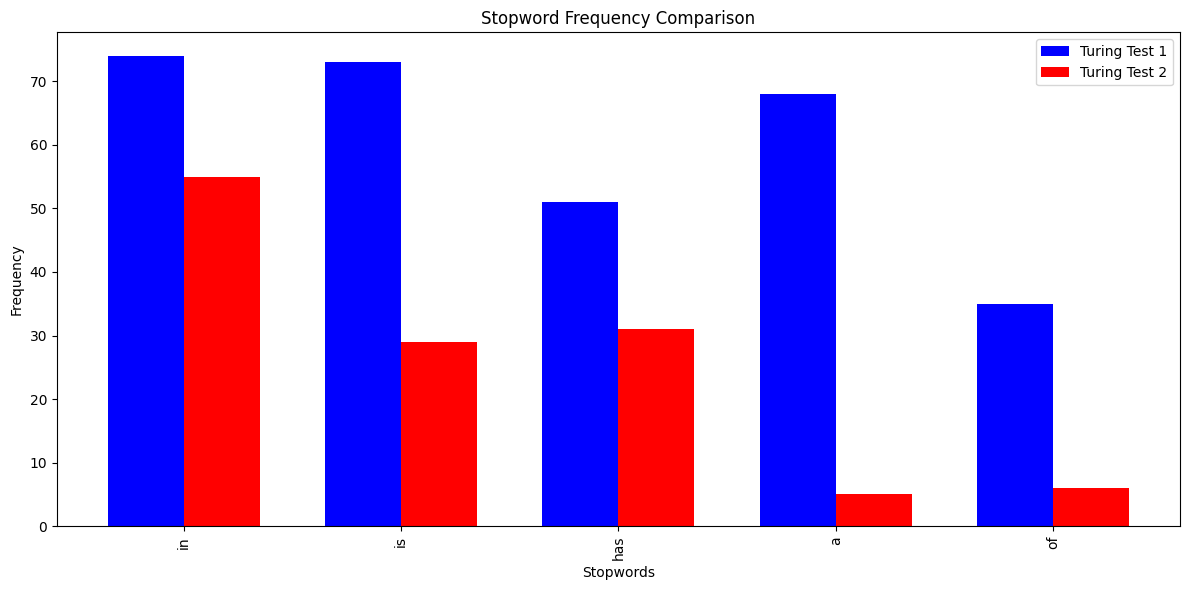

{'detected': 37, 'identified': 4, 'observed': 2}
{'application': 4, 'detected': 2}
detected 37
detected 2


In [61]:
def read_sentences(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        sentences = f.readlines()
    return sentences

def word_frequency(sentences):
    words = {}
    for sentence in sentences:
        sentence = re.sub(r'[^\w\s]', '', sentence)
        for word in sentence.split():
            if word in words:
                words[word] += 1
            else:
                words[word] = 1
    words = {k: v for k, v in sorted(words.items(), key=lambda item: item[1], reverse=True)}
    return words

def tokens_analysis(sentences):
    # min max avegare number of tokens
    num_tokens = []
    for sentence in sentences:
        num_tokens.append(len(sentence.split()))
    min_tokens = min(num_tokens)
    max_tokens = max(num_tokens)
    avg_tokens = sum(num_tokens) / len(num_tokens)
    return min_tokens, max_tokens, avg_tokens

v1_sentences = read_sentences('TuringTest/Version1/synthetic_generate_v1.txt')
v2_sentences = read_sentences('TuringTest/Version2/synthetic_generate_v2.txt')
random.seed(42)
v1_sentences = random.sample(v1_sentences, len(v2_sentences)) # Sample same number of sentences from both versions

v1_words = word_frequency(v1_sentences)
v2_words = word_frequency(v2_sentences)

import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np

nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

v1_stopwords = {k: v for k, v in v1_words.items() if k in stopwords}
v2_stopwords = {k: v for k, v in v2_words.items() if k in stopwords}

def plot_stopword_frequency(v1, v2):
    stopwords = list(set(v1.keys()).intersection(set(v2.keys())))
    combined_frequencies = {word: v1[word] + v2[word] for word in stopwords}
    top_5_stopwords = sorted(combined_frequencies, key=combined_frequencies.get, reverse=True)[:5]
    bar_width = 0.35
    indices = np.arange(len(top_5_stopwords))

    plt.figure(figsize=(12, 6))
    plt.bar(indices, [v1[word] for word in top_5_stopwords], bar_width, color='b', label='Turing Test 1')
    plt.bar(indices + bar_width, [v2[word] for word in top_5_stopwords], bar_width, color='r', label='Turing Test 2')
    plt.xlabel('Stopwords')
    plt.ylabel('Frequency')
    plt.title('Stopword Frequency Comparison')
    plt.xticks(indices + bar_width / 2, top_5_stopwords, rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

print(v1_stopwords)
print(v2_stopwords)
plot_stopword_frequency(v1_stopwords, v2_stopwords)

# Give-away word example 'detected'
v1_blacklist = {k: v for k, v in v1_words.items() if k in BLACKLIST}
v2_blacklist = {k: v for k, v in v2_words.items() if k in BLACKLIST}
print(v1_blacklist)
print(v2_blacklist)

print('detected', v1_words['detected'])
print('detected', v2_words['detected'])

## Verbose Experiment

## Give-away words Experiment

## Prompt Variation Experiment